## Import Libraries

In [5]:
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
import numpy as np
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [6]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
%matplotlib inline
color = sns.color_palette()
from IPython.display import display


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import mlflow # Add MLflow


In [8]:
df=pd.read_csv("D:\Churn Prj\Churn_Modelling.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


array([[<Axes: title={'center': 'RowNumber'}>,
        <Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>],
       [<Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>, <Axes: >]], dtype=object)

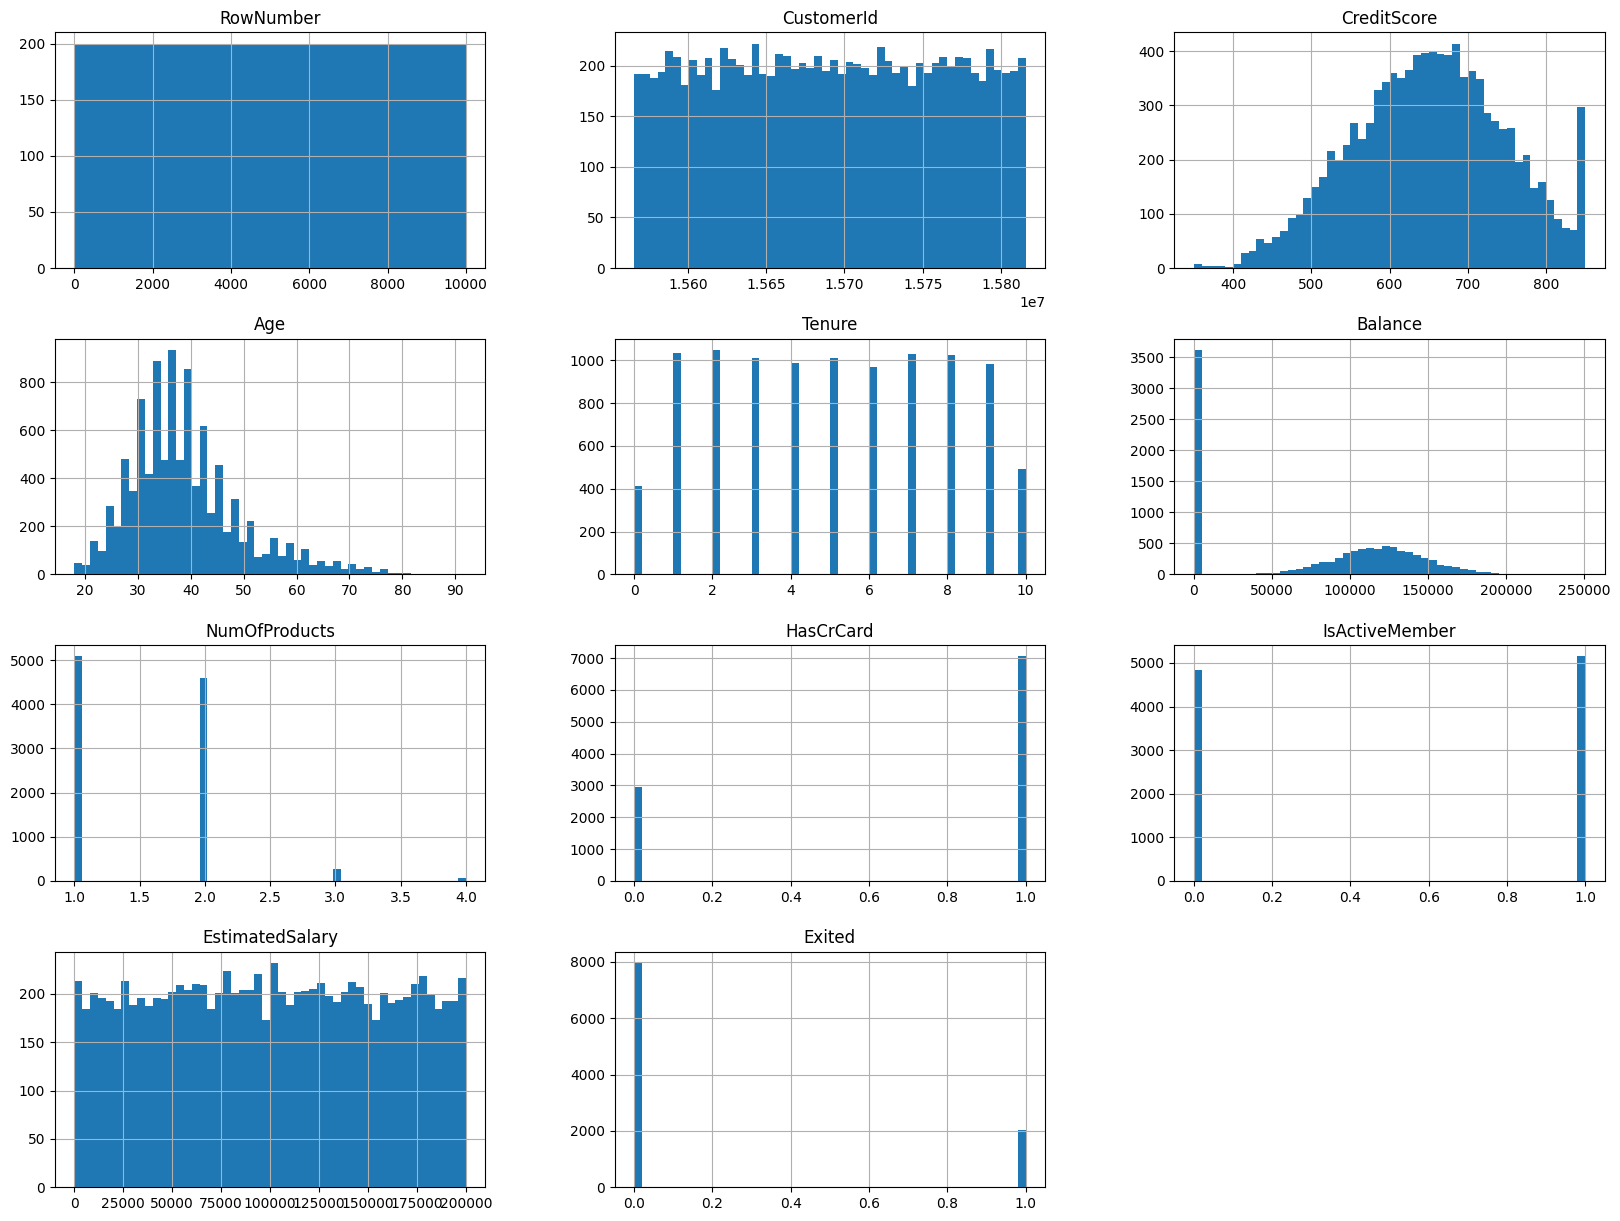

In [10]:
df.hist(bins=50, figsize=(20,15))

In [11]:
df_copy=df.copy()


In [12]:
df_copy.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [13]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [14]:
def split_features(df, discrete_threshold=20):
    """
    Returns dict with keys: 'categorical', 'numeric', 'discrete', 'continuous'.
    - categorical: object/category/bool dtypes
    - numeric: all numeric cols
    - discrete: numeric cols with <= discrete_threshold unique values
    - continuous: numeric cols not in discrete
    """
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    discrete = [c for c in num_cols if df[c].nunique(dropna=True) <= discrete_threshold]
    continuous = [c for c in num_cols if c not in discrete]
    return {
        'categorical': cat_cols,
        'numeric': num_cols,
        'discrete': discrete,
        'continuous': continuous
    }


splits = split_features(df_copy, discrete_threshold=20)
print(splits)

{'categorical': ['Geography', 'Gender'], 'numeric': ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'], 'discrete': ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited'], 'continuous': ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']}


In [15]:
categorical_fet = ['Geography', 'Gender']
discrete_fet = ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
continuous_fet = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

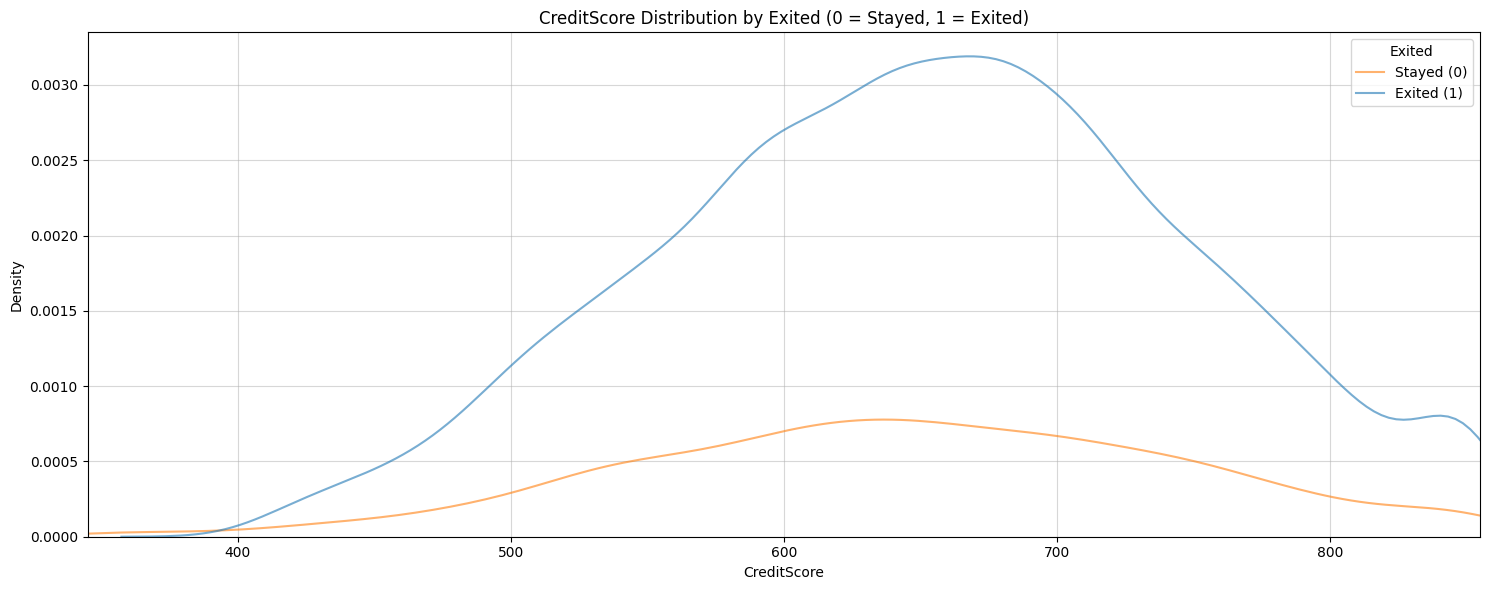

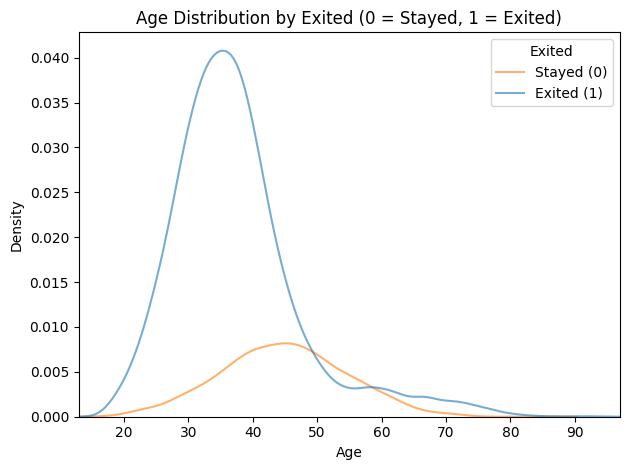

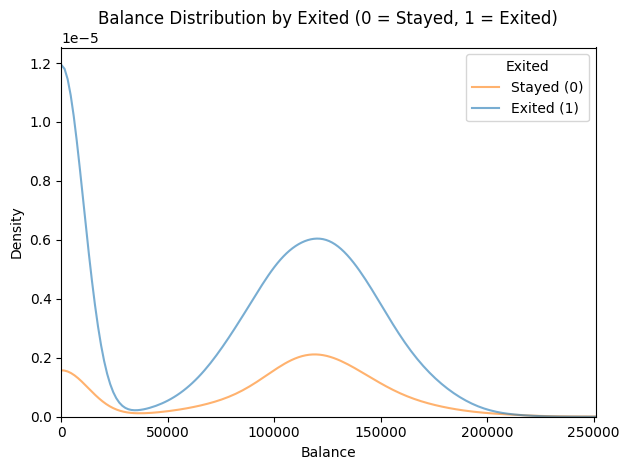

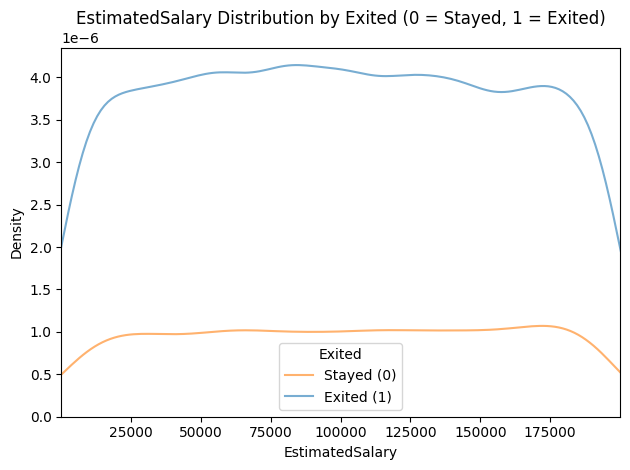

In [16]:
plt.figure(figsize=(15,6))

plt.grid(True, alpha=0.5)
for i in continuous_fet:
    
  sns.kdeplot(data=df_copy, x=i, hue='Exited',
            common_norm=True, multiple='layer', alpha=0.6,
            palette=['C0','C1'])

  plt.xlim(left=max(0, int(df_copy[i].min())-5), right=int(df_copy[i].max())+5)
  plt.xlabel(i)
  plt.ylabel('Density')
  plt.title(f'{i} Distribution by Exited (0 = Stayed, 1 = Exited)')
  plt.legend(title='Exited', labels=['Stayed (0)', 'Exited (1)'])
  plt.tight_layout()
  plt.show()

In [17]:
for col in categorical_fet:
    print(f'--- {col} ---')
    print(df_copy[col].value_counts())
    print()

--- Geography ---
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

--- Gender ---
Gender
Male      5457
Female    4543
Name: count, dtype: int64



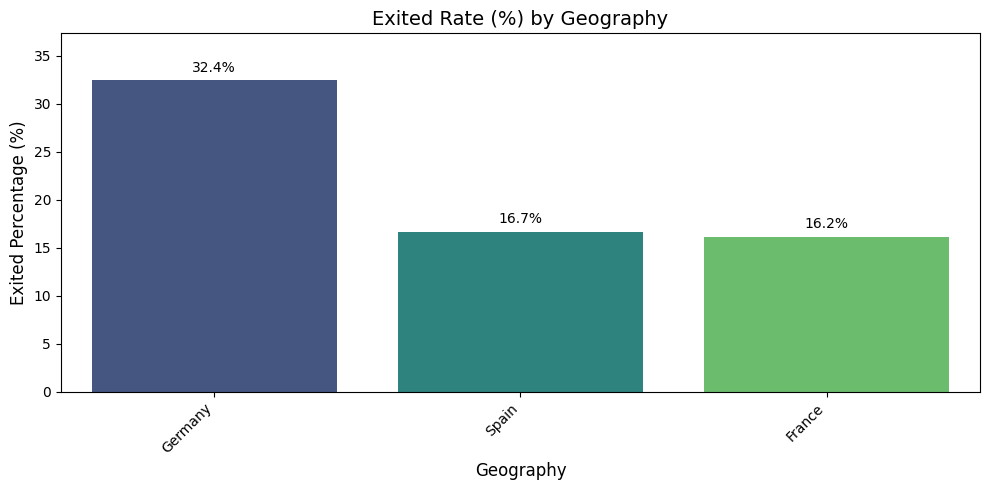

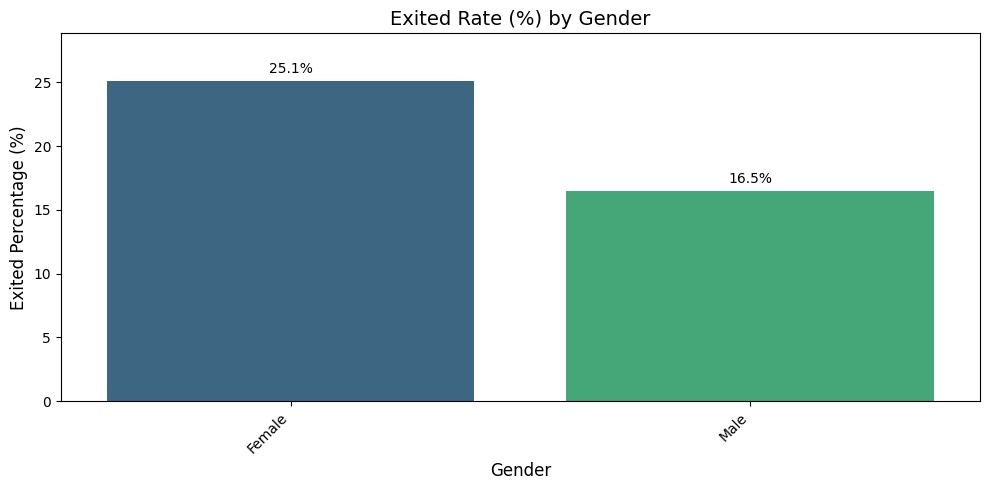

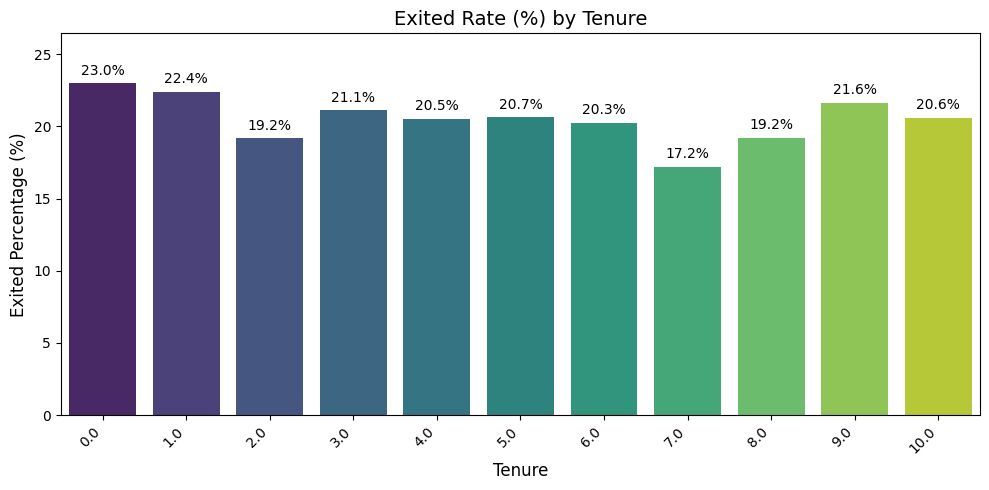

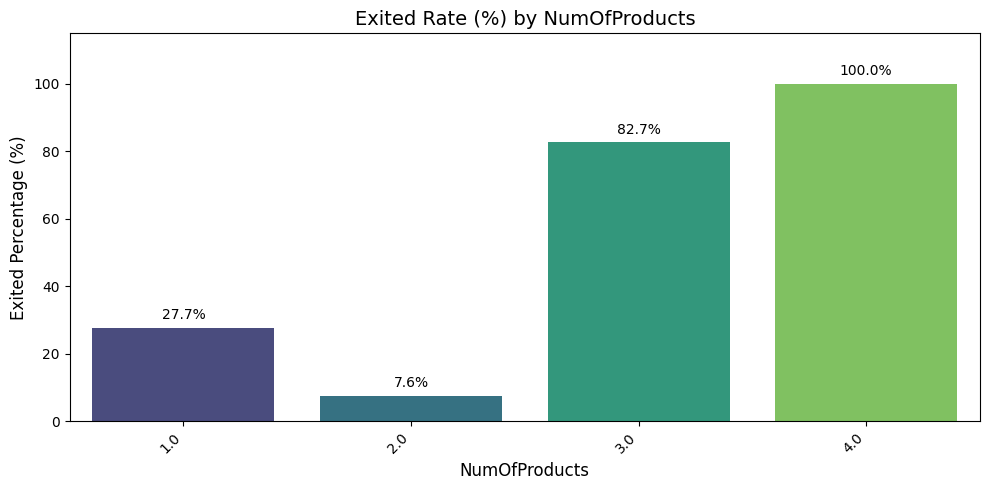

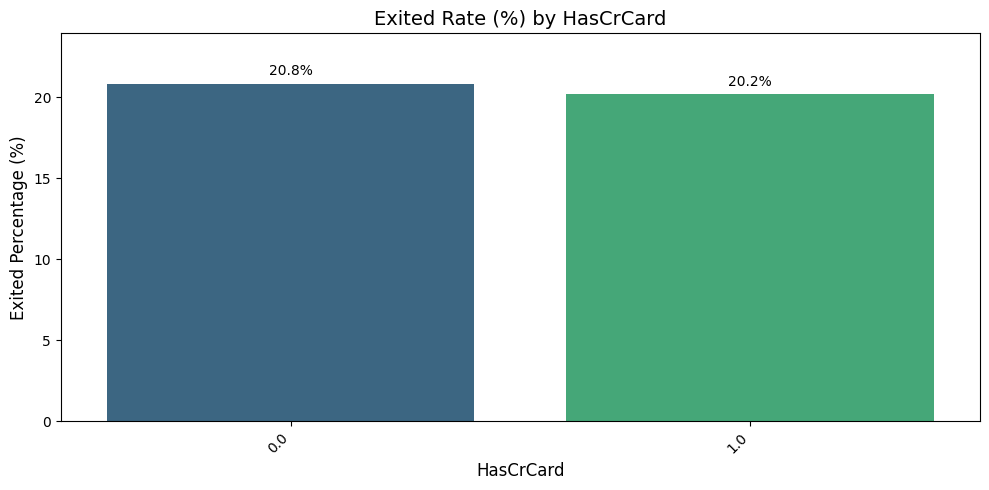

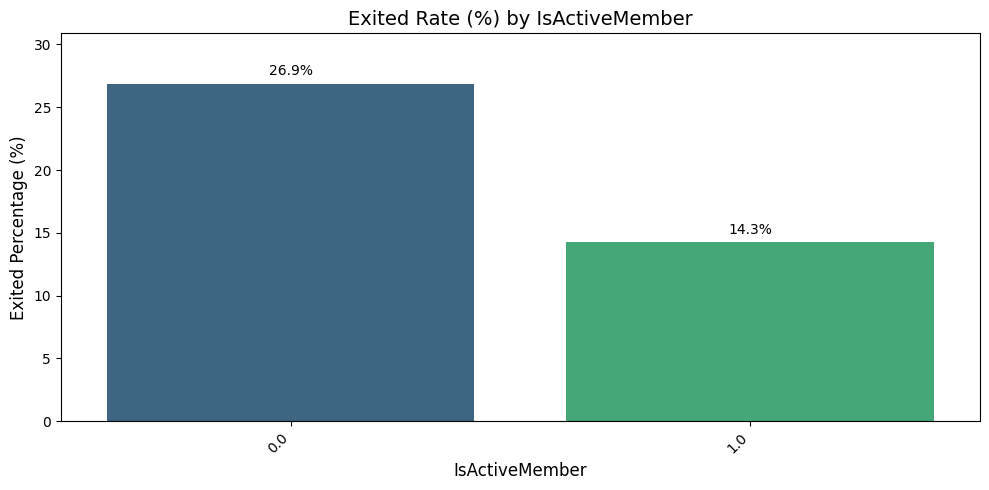

In [18]:
features_to_plot = categorical_fet + discrete_fet
target = 'Exited'

if 'df_copy' not in globals():
    raise RuntimeError("DataFrame `df_copy` not found.")
if 'categorical_fet' not in globals() or 'discrete_fet' not in globals():
    raise RuntimeError("Feature lists `categorical_fet` or `discrete_fet` not found.")

for feature in features_to_plot:
    df_feature = pd.DataFrame(columns=[feature, '% of Exited'])
    i = 0

    for val in list(df_copy[feature].unique()):
        ratio = (
            df_copy[(df_copy[feature] == val) & (df_copy[target] == 1)].shape[0]
            / df_copy[df_copy[feature] == val].shape[0]
        )
        df_feature.loc[i] = (val, ratio * 100)
        i += 1

    df_feature = df_feature.sort_values('% of Exited', ascending=False)

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df_feature, x=feature, y='% of Exited', palette='viridis')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

    plt.title(f'Exited Rate (%) by {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Exited Percentage (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(df_feature['% of Exited']) * 1.15)
    plt.tight_layout()
    plt.show()

In [19]:
df_copy[df_copy['NumOfProducts']==4]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
70,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1
1254,628,France,Female,46,1,46870.43,4,1,0,31272.14,1
1469,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1
1488,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1
1701,792,France,Male,50,9,0.00,4,1,1,194700.81,1
1876,640,Germany,Male,39,9,131607.28,4,0,1,6981.43,1
2124,704,France,Male,32,7,127785.17,4,0,0,184464.70,1
2196,773,Germany,Male,47,2,118079.47,4,1,1,143007.49,1
2285,630,Germany,Male,50,3,129370.91,4,1,1,47775.34,1


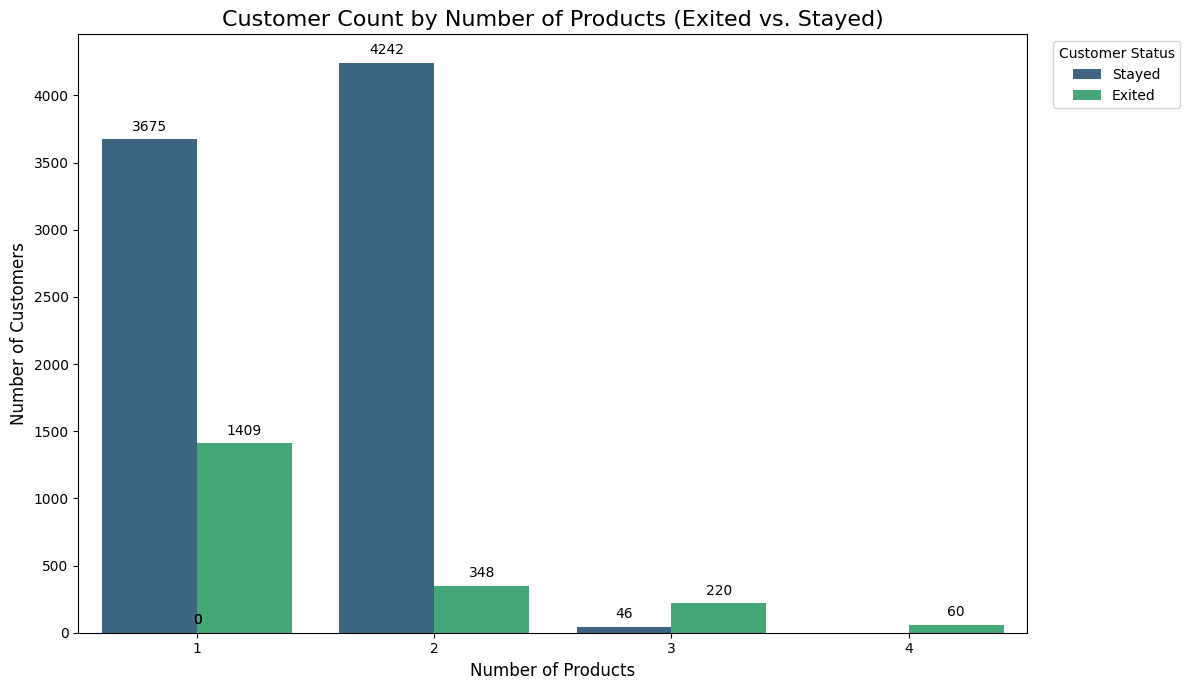

In [20]:
plt.figure(figsize=(12, 7))

ax = sns.countplot(data=df_copy, x='NumOfProducts', hue='Exited', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Customer Count by Number of Products (Exited vs. Stayed)', fontsize=16)
plt.xlabel('Number of Products', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Customize the legend to be more descriptive
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Stayed', 'Exited'], title='Customer Status', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
df_copy.duplicated().sum()

np.int64(0)

--- Overall Box Plots for Continuous Features ---


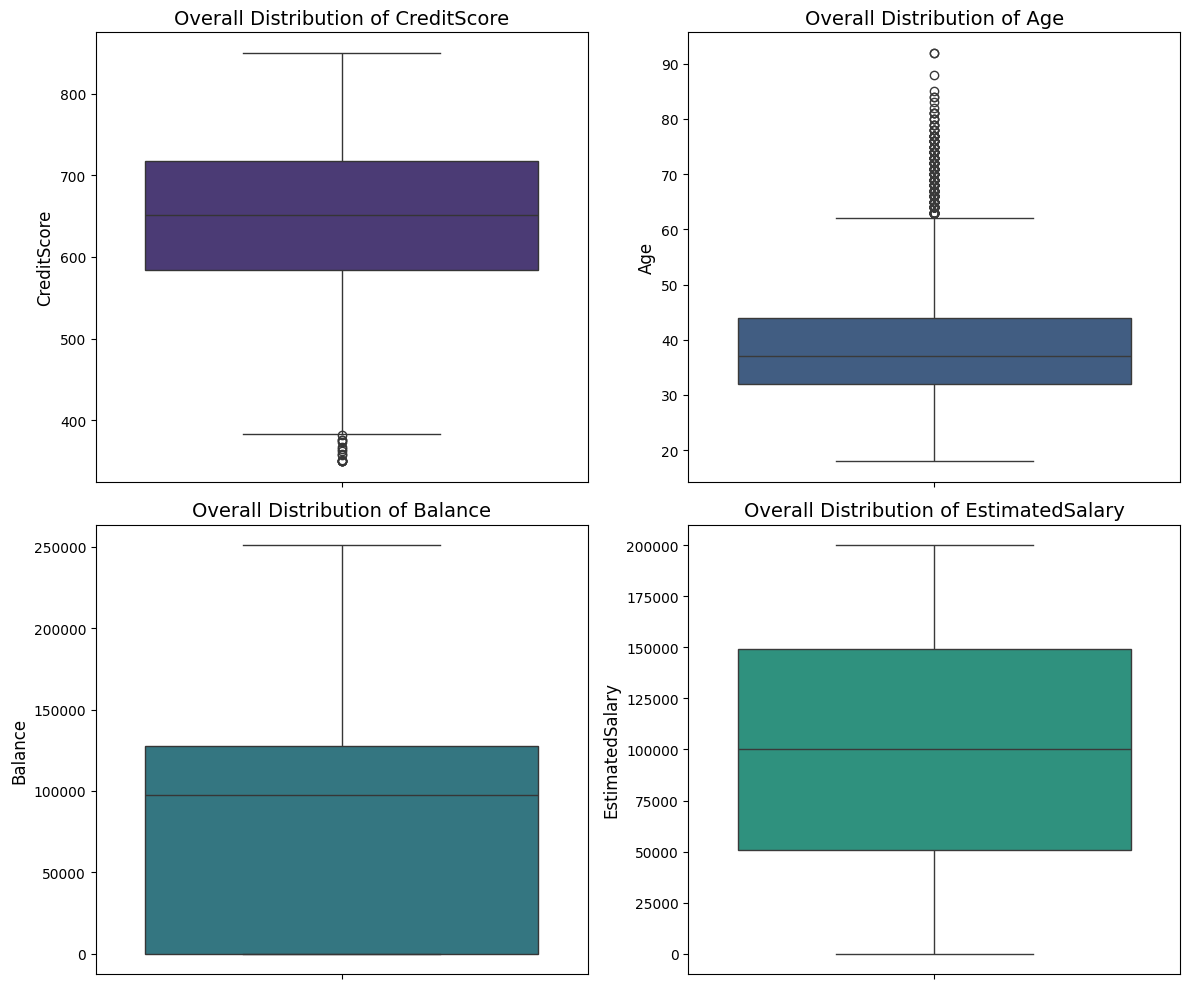

In [22]:
if 'df_copy' not in globals():
    raise RuntimeError("DataFrame `df_copy` not found.")
if 'continuous_fet' not in globals():
    raise RuntimeError("Feature list `continuous_fet` not found.")

print("--- Overall Box Plots for Continuous Features ---")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(continuous_fet):
    ax = axes[i]
    sns.boxplot(data=df_copy, y=feature, ax=ax, color=sns.color_palette('viridis')[i])
    
    # Set titles and labels
    ax.set_title(f'Overall Distribution of {feature}', fontsize=14)
    ax.set_ylabel(feature, fontsize=12)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

In [23]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [24]:
df_copy['Balance_to_Salary'] = df_copy['Balance'] / (df_copy['EstimatedSalary'] + 1)


In [25]:
df_copy['Credit_Stability'] = df_copy['CreditScore'] / (df_copy['Age'] + 1)

In [26]:
numeric_fet = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary','Balance_to_Salary','Credit_Stability','Exited']


--- Correlation Matrix for Numerical Features ---


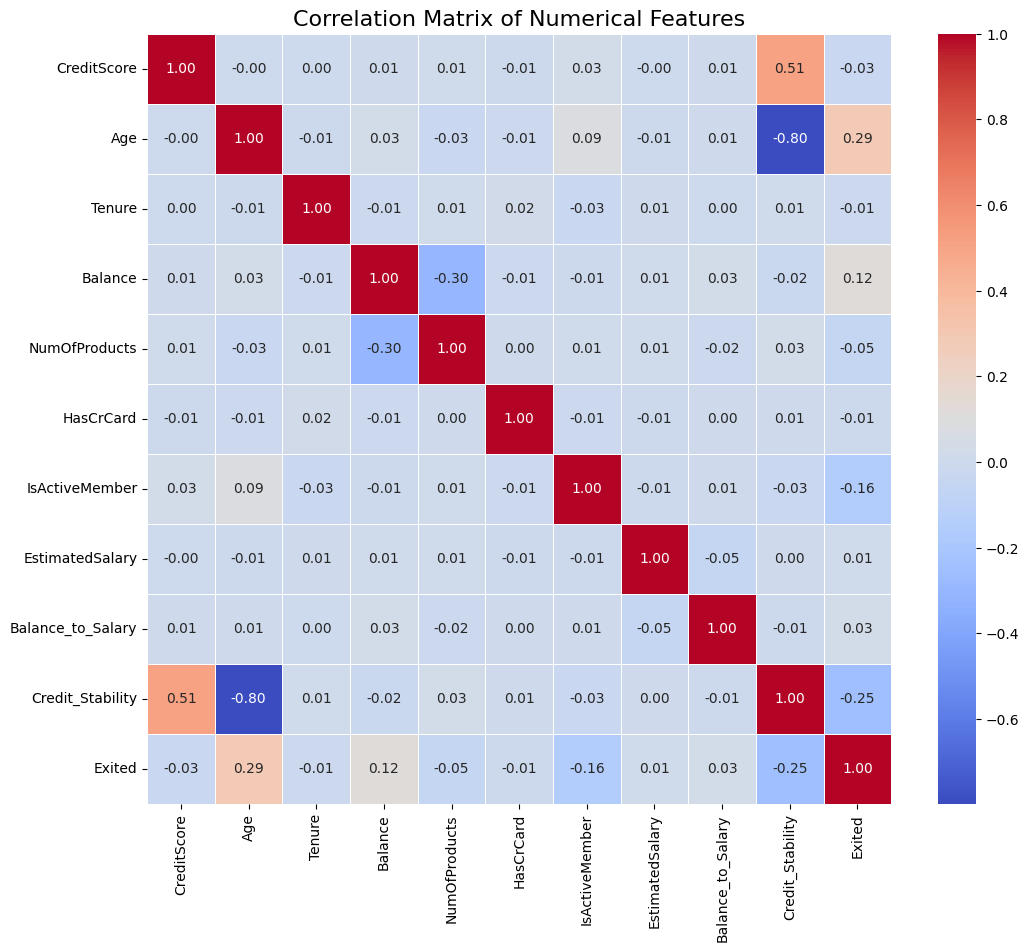

In [27]:
if 'df_copy' not in globals():
    raise RuntimeError("DataFrame `df_copy` not found.")
if 'numeric_fet' not in globals():
    raise RuntimeError("Feature list `numeric_fet` not found.")

print("--- Correlation Matrix for Numerical Features ---")

numeric_df = df_copy[numeric_fet]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,      
            cmap='coolwarm', 
            fmt=".2f",       
            linewidths=.5)   

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()



In [28]:
print(categorical_fet)

['Geography', 'Gender']


In [29]:
df_copy['Gender'] = df_copy['Gender'].map({'Male': 1, 'Female': 0})
df_copy = pd.get_dummies(df_copy, columns=['Geography'], drop_first=True,dtype=int)

In [30]:
df_copy.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Salary,Credit_Stability,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0.000000,14.395349,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.744670,14.476190,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.401362,11.674419,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0.000000,17.475000,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1.587035,19.318182,0,1


In [31]:
df_copy.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Salary,Credit_Stability,Geography_Germany,Geography_Spain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,3.790150,17.366444,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,100.055758,5.108737,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,4.800000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,13.769231,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.746998,16.824265,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.514002,20.333333,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,9770.883148,44.421053,1.000000,1.000000


In [32]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
features_to_scale = [
    'CreditScore',
    'Age',
    'Balance',
    'EstimatedSalary',
    'Balance_to_Salary',
    'Credit_Stability'
]

In [35]:
scaler = MinMaxScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [36]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Original training set shape:", y_train.shape)
print("Original training set distribution:\n", y_train.value_counts())
print("\nResampled training set shape:", y_train_smote.shape)
print("Resampled training set distribution:\n", y_train_smote.value_counts())


Original training set shape: (8000,)
Original training set distribution:
 Exited
0    6370
1    1630
Name: count, dtype: int64

Resampled training set shape: (12740,)
Resampled training set distribution:
 Exited
1    6370
0    6370
Name: count, dtype: int64


In [37]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

training_sets = {
    "Original Training Data": (X_train, y_train),
    "SMOTE Training Data": (X_train_smote, y_train_smote)
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']


results_list = []

for d_name, (X_data, y_data) in training_sets.items():
    print(f"=======================================================")
    print(f"  RUNNING 5-FOLD CROSS-VALIDATION ON: {d_name.upper()}")
    print(f"=======================================================\n")
    
    # Loop through each model
    for m_name, model in models.items():
        print(f"--- Evaluating: {m_name} ---")
        
        # Perform 5-fold cross-validation
        cv_results = cross_validate(
            estimator=model,
            X=X_data,
            y=y_data,
            cv=5,  
            scoring=scoring_metrics,
            n_jobs=-1 
        )
        
        
        results_list.append({
            'Dataset': d_name,
            'Model': m_name,
            'Mean Accuracy': cv_results['test_accuracy'].mean(),
            'Mean Precision': cv_results['test_precision_macro'].mean(),
            'Mean Recall': cv_results['test_recall_macro'].mean(),
            'Mean F1-Score': cv_results['test_f1_macro'].mean(),
            'Mean ROC AUC': cv_results['test_roc_auc'].mean()
        })
        print(f"Done with {m_name}.\n")


results_df = pd.DataFrame(results_list)

results_df.style.background_gradient(cmap='viridis', subset=['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1-Score', 'Mean ROC AUC'])


  RUNNING 5-FOLD CROSS-VALIDATION ON: ORIGINAL TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Random Forest.

--- Evaluating: XGBoost ---
Done with Random Forest.

--- Evaluating: XGBoost ---
Done with XGBoost.

  RUNNING 5-FOLD CROSS-VALIDATION ON: SMOTE TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with XGBoost.

  RUNNING 5-FOLD CROSS-VALIDATION ON: SMOTE TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Random Forest.

--- Evaluating: XGBoos

,Dataset,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score,Mean ROC AUC
0,Original Training Data,Logistic Regression,0.812875,0.723378,0.589644,0.604085,0.767325
1,Original Training Data,Decision Tree,0.800125,0.692275,0.692570,0.692350,0.692570
2,Original Training Data,Random Forest,0.858750,0.816651,0.706330,0.739812,0.852888
3,Original Training Data,XGBoost,0.854000,0.789960,0.721607,0.746445,0.841865
4,SMOTE Training Data,Logistic Regression,0.718132,0.718262,0.718132,0.718091,0.788564
5,SMOTE Training Data,Decision Tree,0.808320,0.812733,0.808320,0.807307,0.808320
6,SMOTE Training Data,Random Forest,0.880141,0.881657,0.880141,0.879993,0.949154
7,SMOTE Training Data,XGBoost,0.871586,0.881678,0.871586,0.869497,0.947488


In [38]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

X_train_final, y_train_final = X_train_smote, y_train_smote  

test_results = []

for name, model in models.items():
    model.fit(X_train_final, y_train_final)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] 
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    test_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc
    })

test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df.sort_values(by="F1-Score", ascending=False)

test_results_df.style.background_gradient(
    cmap="viridis",
    subset=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Random Forest,0.829000,0.572707,0.628993,0.599532,0.844601
3,XGBoost,0.833500,0.594872,0.570025,0.582183,0.834500
1,Decision Tree,0.754000,0.426343,0.604423,0.500000,0.698319
0,Logistic Regression,0.705500,0.379630,0.705160,0.493551,0.776007


--- Building the Final, Optimized Random Forest Model ---
Training the final model on the full SMOTE dataset...
Training complete.

--- Final Evaluation on the Test Set ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.58      0.61      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000

Final F1-Score on Test Set: 0.5930
Training complete.

--- Final Evaluation on the Test Set ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.58      0.61      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000

Final F1-Score on Test Set: 0

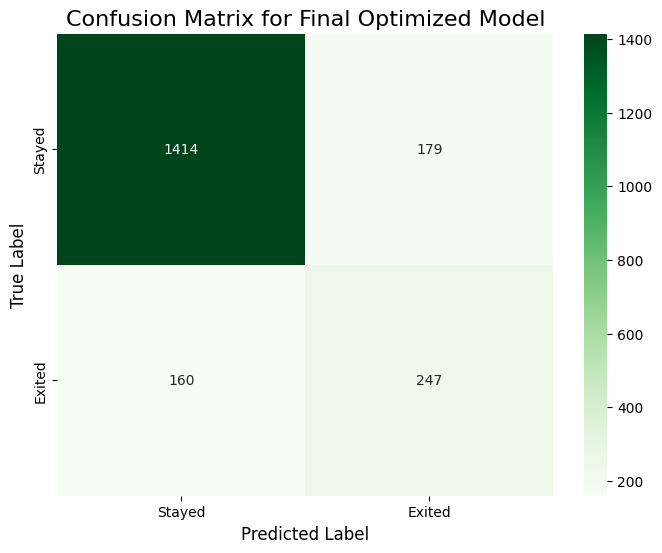


--- Feature Importances from the Final Model ---


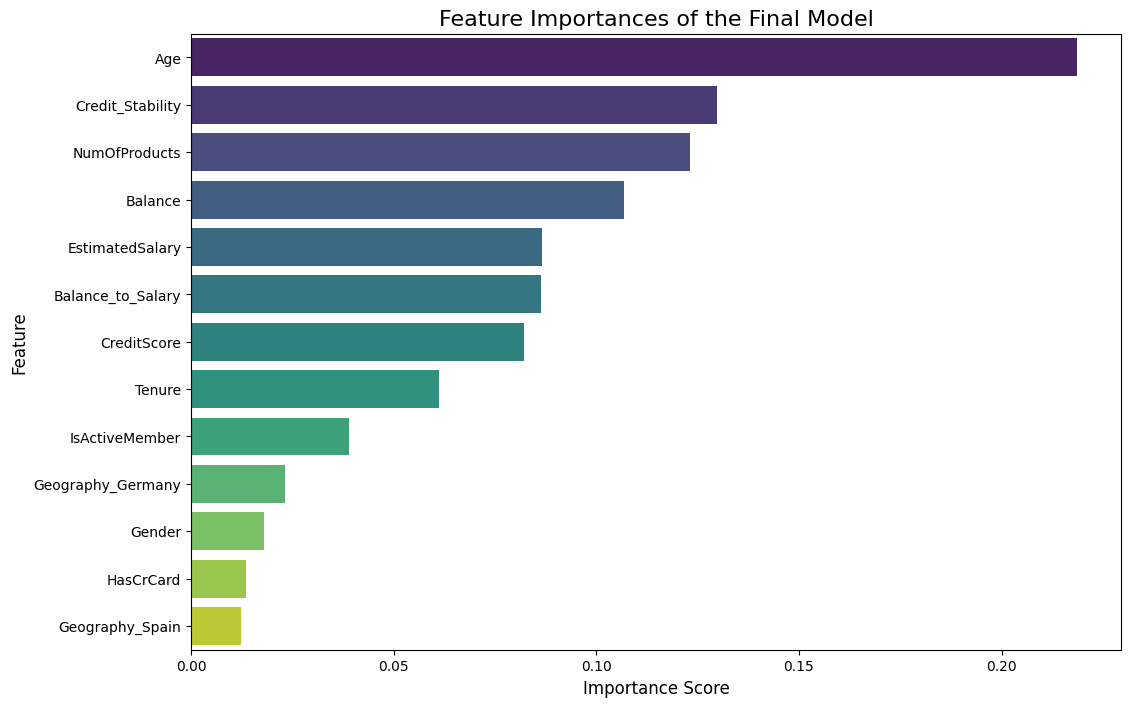

In [39]:
print("--- Building the Final, Optimized Random Forest Model ---")

best_params = {
    'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': None,
    'bootstrap': False,
    'random_state': 42, 
    'n_jobs': -1
}

# Create the final model instance
final_model = RandomForestClassifier(**best_params)

print("Training the final model on the full SMOTE dataset...")
final_model.fit(X_train_smote, y_train_smote)
print("Training complete.")

print("\n--- Final Evaluation on the Test Set ---")
y_pred_final = final_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

final_f1 = f1_score(y_test, y_pred_final)
print(f"Final F1-Score on Test Set: {final_f1:.4f}")

cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Stayed', 'Exited'],
            yticklabels=['Stayed', 'Exited'])
plt.title('Confusion Matrix for Final Optimized Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

print("\n--- Feature Importances from the Final Model ---")
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances of the Final Model', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


## MLflow Experiment Tracking
Here we will use MLflow to log the cross-validation results for our baseline models.


In [40]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

training_sets = {
    "Original Training Data": (X_train, y_train),
    "SMOTE Training Data": (X_train_smote, y_train_smote)
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']


results_list = []

for d_name, (X_data, y_data) in training_sets.items():
    print(f"=======================================================")
    print(f"  RUNNING 5-FOLD CROSS-VALIDATION ON: {d_name.upper()}")
    print(f"=======================================================\n")
    
    # Loop through each model
    for m_name, model in models.items():
        print(f"--- Evaluating: {m_name} ---")
        
        # Perform 5-fold cross-validation
        cv_results = cross_validate(
            estimator=model,
            X=X_data,
            y=y_data,
            cv=5,  
            scoring=scoring_metrics,
            n_jobs=-1 
        )
        
        
        results_list.append({
            'Dataset': d_name,
            'Model': m_name,
            'Mean Accuracy': cv_results['test_accuracy'].mean(),
            'Mean Precision': cv_results['test_precision_macro'].mean(),
            'Mean Recall': cv_results['test_recall_macro'].mean(),
            'Mean F1-Score': cv_results['test_f1_macro'].mean(),
            'Mean ROC AUC': cv_results['test_roc_auc'].mean()
        })
        print(f"Done with {m_name}.\n")


results_df = pd.DataFrame(results_list)

results_df.style.background_gradient(cmap='viridis', subset=['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1-Score', 'Mean ROC AUC'])

  RUNNING 5-FOLD CROSS-VALIDATION ON: ORIGINAL TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Random Forest.

--- Evaluating: XGBoost ---
Done with Random Forest.

--- Evaluating: XGBoost ---
Done with XGBoost.

  RUNNING 5-FOLD CROSS-VALIDATION ON: SMOTE TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with XGBoost.

  RUNNING 5-FOLD CROSS-VALIDATION ON: SMOTE TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Random Forest.

--- Evaluating: XGBoos

,Dataset,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score,Mean ROC AUC
0,Original Training Data,Logistic Regression,0.812875,0.723378,0.589644,0.604085,0.767325
1,Original Training Data,Decision Tree,0.800125,0.692275,0.692570,0.692350,0.692570
2,Original Training Data,Random Forest,0.858750,0.816651,0.706330,0.739812,0.852888
3,Original Training Data,XGBoost,0.854000,0.789960,0.721607,0.746445,0.841865
4,SMOTE Training Data,Logistic Regression,0.718132,0.718262,0.718132,0.718091,0.788564
5,SMOTE Training Data,Decision Tree,0.808320,0.812733,0.808320,0.807307,0.808320
6,SMOTE Training Data,Random Forest,0.880141,0.881657,0.880141,0.879993,0.949154
7,SMOTE Training Data,XGBoost,0.871586,0.881678,0.871586,0.869497,0.947488


In [41]:
import mlflow
mlflow.set_experiment("Churn Model Comparison")

# Start a parent run to group all the cross-validation runs
with mlflow.start_run(run_name="Cross-Validation Experiment"):
    mlflow.log_param("description", "Running CV for 4 models on original and SMOTE data.")

    for d_name, (X_data, y_data) in training_sets.items():
        print(f"=======================================================")
        print(f"  RUNNING 5-FOLD CROSS-VALIDATION ON: {d_name.upper()}")
        print(f"=======================================================\n")
        
        for m_name, model in models.items():
            # Start a nested run for each model and dataset combination
            with mlflow.start_run(run_name=f"{m_name} on {d_name}", nested=True):
                print(f"--- Evaluating: {m_name} ---")
                
                # Log parameters for this specific run
                mlflow.log_param("model_name", m_name)
                mlflow.log_param("dataset", d_name)
                
                # Perform 5-fold cross-validation
                cv_results = cross_validate(
                    estimator=model,
                    X=X_data,
                    y=y_data,
                    cv=5,  
                    scoring=scoring_metrics,
                    n_jobs=-1 
                )
                
                # Calculate and log mean scores
                mlflow.log_metric("mean_accuracy", cv_results['test_accuracy'].mean())
                mlflow.log_metric("mean_precision", cv_results['test_precision_macro'].mean())
                mlflow.log_metric("mean_recall", cv_results['test_recall_macro'].mean())
                mlflow.log_metric("mean_f1_score", cv_results['test_f1_macro'].mean())
                mlflow.log_metric("mean_roc_auc", cv_results['test_roc_auc'].mean())

                print(f"Done with {m_name}.\n")

print("\nMLflow tracking complete. Run '!mlflow ui' in a new cell to see the results.")

  RUNNING 5-FOLD CROSS-VALIDATION ON: ORIGINAL TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Random Forest.

--- Evaluating: XGBoost ---
Done with Random Forest.

--- Evaluating: XGBoost ---
Done with XGBoost.

  RUNNING 5-FOLD CROSS-VALIDATION ON: SMOTE TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with XGBoost.

  RUNNING 5-FOLD CROSS-VALIDATION ON: SMOTE TRAINING DATA

--- Evaluating: Logistic Regression ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Logistic Regression.

--- Evaluating: Decision Tree ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Decision Tree.

--- Evaluating: Random Forest ---
Done with Random Forest.

--- Evaluating: XGBoos

## MLflow Test Set Evaluation
Now we will log the performance of the final models on the unseen test set.

In [42]:
# Set a new experiment for the test evaluation
mlflow.set_experiment("Churn Test Set Evaluation")

X_train_final, y_train_final = X_train_smote, y_train_smote  

test_results_list = []

for name, model in models.items():
    # Start a new run for each model
    with mlflow.start_run(run_name=f"Test - {name}"):
        print(f"--- Training and Evaluating: {name} on Test Set ---")
        
        # Train the model on the full SMOTE training data
        model.fit(X_train_final, y_train_final)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] 
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_prob)
        
        # Log parameters and metrics to MLflow
        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc)
        
        # Log the model itself
        mlflow.sklearn.log_model(model, f"model_{name.replace(' ', '_')}")
        
        # Append results for DataFrame display
        test_results_list.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC-AUC": roc
        })
        print(f"Done with {name}.\n")

# Create and display the results DataFrame
test_results_df = pd.DataFrame(test_results_list)
test_results_df = test_results_df.sort_values(by="F1-Score", ascending=False)

print("--- Test Set Evaluation Results ---")
display(test_results_df.style.background_gradient(
    cmap="viridis",
    subset=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
))

print("\nMLflow tracking for test set complete. Check the 'Churn Test Set Evaluation' experiment in the UI.")

2025/11/02 15:46:00 INFO mlflow.tracking.fluent: Experiment with name 'Churn Test Set Evaluation' does not exist. Creating a new experiment.


--- Training and Evaluating: Logistic Regression on Test Set ---


2025/11/02 15:46:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/02 15:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/02 15:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Done with Logistic Regression.

--- Training and Evaluating: Decision Tree on Test Set ---


2025/11/02 15:46:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/02 15:46:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/02 15:46:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Done with Decision Tree.

--- Training and Evaluating: Random Forest on Test Set ---


2025/11/02 15:46:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/02 15:46:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/02 15:46:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Done with Random Forest.

--- Training and Evaluating: XGBoost on Test Set ---


2025/11/02 15:46:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/02 15:46:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/02 15:46:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Done with XGBoost.

--- Test Set Evaluation Results ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Random Forest,0.829000,0.572707,0.628993,0.599532,0.844601
3,XGBoost,0.833500,0.594872,0.570025,0.582183,0.834500
1,Decision Tree,0.754000,0.426343,0.604423,0.500000,0.698319
0,Logistic Regression,0.705500,0.379630,0.705160,0.493551,0.776007



MLflow tracking for test set complete. Check the 'Churn Test Set Evaluation' experiment in the UI.


## Save Model and Scaler for API
We need to save the final model and the scaler object to use them in our FastAPI application. We'll use `joblib` for this.


In [43]:
import joblib

# File paths for the model and scaler
model_path = 'final_churn_model.pkl'
scaler_path = 'scaler.pkl'

# Save the final_model
print(f"Saving model to {model_path}...")
joblib.dump(final_model, model_path)
print("Model saved successfully.")

# Save the scaler
print(f"Saving scaler to {scaler_path}...")
joblib.dump(scaler, scaler_path)
print("Scaler saved successfully.")


Saving model to final_churn_model.pkl...
Model saved successfully.
Saving scaler to scaler.pkl...
Scaler saved successfully.
Scaler saved successfully.
